## Imports/setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys, os
if '..' not in sys.path: sys.path.append('..')

from fqc import uccsd, util, models
import numpy as np
import h5py

import config
data_path = config.DATA_PATH

import matplotlib
import matplotlib.pyplot as plt

## Creating Unoptimized Circuit

In [2]:
theta_vector = [np.random.rand() * 2 * np.pi for _ in range(8)]
print(theta_vector)

[1.2826269455565023, 3.62387694343466, 2.8054670800974764, 3.2994757840587816, 3.598264269628034, 6.273228636559141, 6.222894965789146, 1.8618092988303725]


In [3]:
circuit = uccsd.get_uccsd_circuit('LiH', theta_vector)
circuit.draw(output='text', line_length=4000)

In [4]:
unoptimized_unitary = util.get_unitary(circuit)
util.circuitutil.get_max_pulse_time(circuit)

995.1000000000039

## Optimizing Circuit

In [5]:
coupling_list = util.circuitutil.get_nearest_neighbor_coupling_list(2, 2)
optimized_circuit = util.optimize_circuit(circuit, coupling_list)

In [6]:
optimized_circuit.draw(output='text', line_length=4000)

In [7]:
optimized_unitary = util.get_unitary(optimized_circuit)
util.circuitutil.get_max_pulse_time(optimized_circuit)

932.1000000000035

## Getting Example Circuit Slice + Generating $U(\theta)$ at different angles

In [8]:
from qiskit import QuantumRegister, QuantumCircuit
from qiskit.extensions.standard import RZGate

In [9]:
slices = uccsd.get_uccsd_runs(optimized_circuit)

In [10]:
my_slice = slices[3]
unitaries = {}
angle_range = np.linspace(0, 60, 60 / 1.5 + 1)
for i, angle in enumerate(angle_range):
    my_slice.update_angles([angle * np.pi / 180.0])
    unitaries[angle] = util.get_unitary(my_slice.circuit)
    
    sys.stdout.write("\rGenerated Unitaries: " + str(i) + "/" + str(len(angle_range) -1 ))
    sys.stdout.flush()

Generated Unitaries: 6/40

/home/cwinkler/.local/lib/python3.6/site-packages/ipykernel/__main__.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  app.launch_new_instance()


Generated Unitaries: 40/40

## Generating $U\left(\frac{\pi}{2}\right)$ as a starting point

In [11]:
from quantum_optimal_control.helper_functions.grape_functions import transmon_gate
from quantum_optimal_control.main_grape.grape import Grape
from quantum_optimal_control.core import hamiltonian

In [12]:
import os, sys, math
from datetime import datetime
sys.path.append('..'); import config

data_path = config.DATA_PATH
file_name = datetime.today().strftime('%h%d')

In [18]:
d = 2  # this is the number of energy levels to consider (i.e. d-level qudits)
max_iterations = 1000
decay =  max_iterations / 2
convergence = {'rate':0.02, 'max_iterations':max_iterations,
               'conv_target':1e-3, 'learning_rate_decay':decay, 'min_grad': 1e-5}
reg_coeffs = {'dwdt': 0.001, 'envelope': 0.01}

In [14]:
N = 4 # Number of qubits for the circuit
connected_qubit_pairs = util.circuitutil.get_nearest_neighbor_coupling_list(2, 2, directed=False)

H0 = hamiltonian.get_H0(N, d)
Hops, Hnames = hamiltonian.get_Hops_and_Hnames(N, d, connected_qubit_pairs)
states_concerned_list = hamiltonian.get_full_states_concerned_list(N, d)
maxA = hamiltonian.get_maxA(N, d, connected_qubit_pairs)

In [19]:
total_time = 60.0
steps = int(total_time * 20)

U = transmon_gate(unitaries[30], d)
SS, wall_time = Grape(H0, Hops, Hnames, U, total_time, steps, states_concerned_list, convergence,
                 reg_coeffs=reg_coeffs,
                 use_gpu=False, sparse_H=False, method='ADAM', maxA=maxA,
                 show_plots=False, file_name=file_name, data_path=data_path)

data saved at: /project/ftchong/qoc/chris/00003_Mar08.h5
Using 5 Taylor terms and 4 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :9.66e-01; Runtime: 2.2s; Iterations = 0, grads =   2.018e-01, unitary_metric = 1.00037
Error = :5.91e-04; Runtime: 95.3s; Iterations = 76, grads =   7.113e-02, unitary_metric = 1.00030
data saved at: /project/ftchong/qoc/chris/00003_Mar08.h5


Error: 5.913377e-04


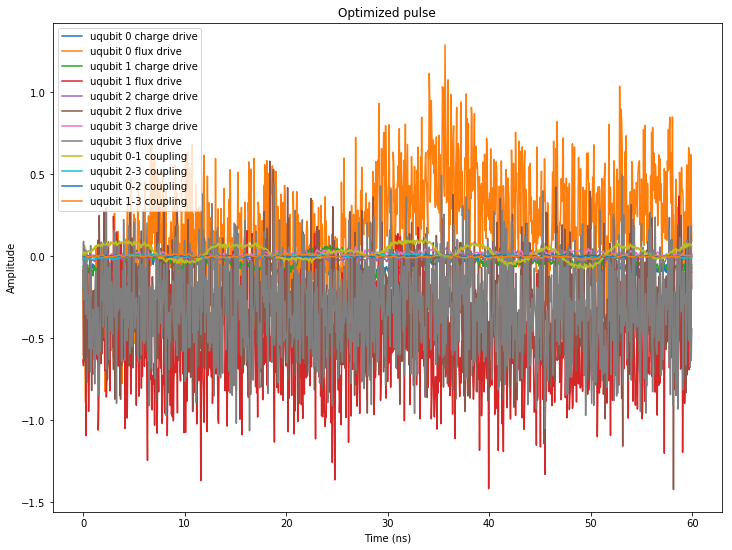

In [21]:
from fqc.models import Pulse
fname_h1 = '/project/ftchong/qoc/chris/00003_Mar08.h5' #Change this
qubits = [0] # index of qubit the pulse is acting on
pulse = Pulse(N, d, qubits, fname=fname_h1)
util.plot_pulse(pulse)

In [32]:
from fqc.models import Pulse
transmon_unitaries = {}
conv_data = {}
guess_pulse = Pulse(N, d, range(4), fname='/project/ftchong/qoc/chris/00000_Feb25.h5')

for angle in angle_range:
    #if angle == 30:
    #    continue
    if angle == 60:
        print("---EVOLVING ANGLE: {}---".format(angle))
        transmon_unitaries[angle] = transmon_gate(unitaries[angle], d)
        #rel_convergence = {'rate':0.002, 'max_iterations':max_iterations,
        #           'conv_target':1e-3, 'learning_rate_decay':decay}
        conv_data[angle] = util.evol_pulse(guess_pulse, transmon_unitaries[angle], save=False)

        #Grape(H0, Hops, Hnames, transmon_unitaries[angle], total_time, steps, states_concerned_list, rel_convergence,
        #             initial_guess=guess_pulse.uks,
        #             reg_coeffs=reg_coeffs,
        #             use_gpu=False, sparse_H=False, method='ADAM', maxA=maxA,
        #             show_plots=False, file_name=file_name, data_path=data_path,
        #             save=False)

import pickle
#with open(os.path.join(data_path, 'theta_errors.pickle'), 'wb') as fn:
#    pickle.dump({angle: conv_data[angle].l for angle in angle_range}, fn)

---EVOLVING ANGLE: 60.0---
Using 6 Taylor terms and 6 Scaling & Squaring terms
Building graph:
Propagators initialized.
Operators weight initialized.
Intermediate propagation variables initialized.
Intermediate propagators initialized.
Vectors initialized.
Training loss initialized.
Optimizer initialized.
Utilities initialized.
Graph built!
Initialized
Error = :6.78e-02; Runtime: 2.0s; Iterations = 0, grads =   5.395e-01, unitary_metric = 0.99935


## Analysis

In [30]:
with open(os.path.join(data_path, 'theta_errors.pickle'), 'rb') as fn:
    loaded_conv_data = pickle.load(fn)

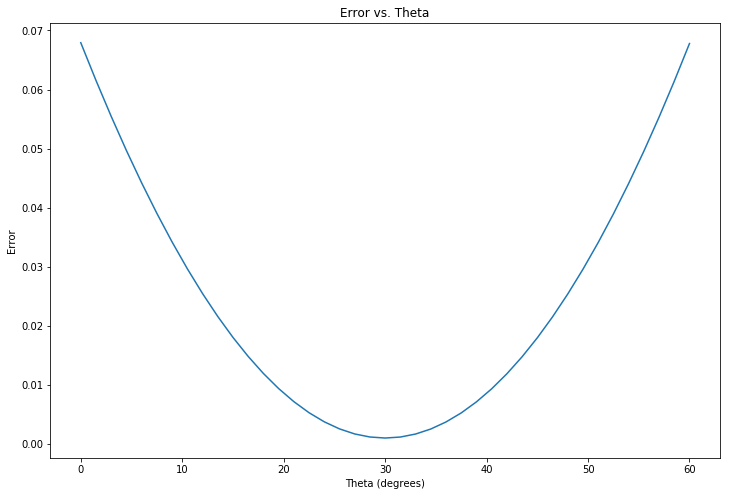

In [36]:

def construct_error_list(accessor):
    return [accessor(loaded_conv_data[f]) for f in angle_range]

plt.figure(figsize=(12,8))
plt.plot(angle_range, construct_error_list(lambda x: x))
plt.xlabel('Theta (degrees)')
plt.ylabel('Error')
plt.title('Error vs. Theta')
plt.show()

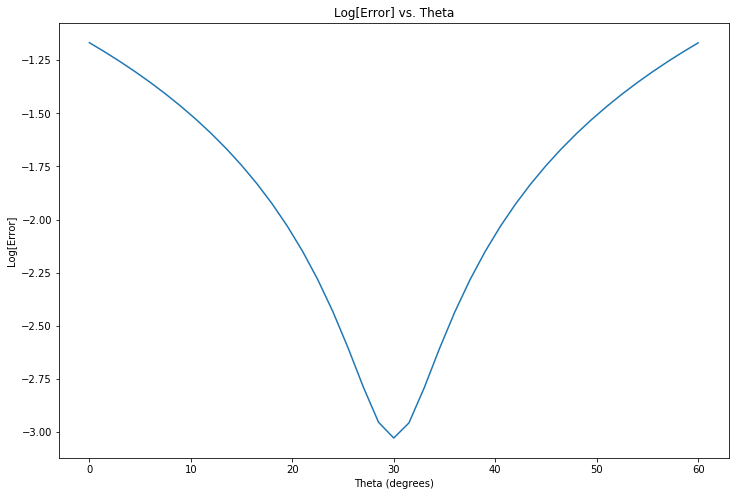

In [38]:
plt.figure(figsize=(12,8))
plt.plot(angle_range, np.log10(construct_error_list(lambda x: x)))
plt.xlabel('Theta (degrees)')
plt.ylabel('Log[Error]')
plt.title('Log[Error] vs. Theta')
plt.show()